<a href="https://colab.research.google.com/github/Jersae/Google-TimeSeries-workshop/blob/main/Quantile_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip3 install lightgbm

### Intuition of Quantile Loss 


modified from https://github.com/ajhalthor/quantile-regression/blob/main/Quantile%20Regression.ipynb


Typical Loss Function:

$$ L = (y - \zeta)^2 $$

Quantile Loss:

$$
\begin{equation}
  L =
    \begin{cases}
      \tau (y - \zeta) & \text{if $y - \zeta\ge 0$}\\
      (\tau - 1) (y - \zeta) & \text{if $y - \zeta < 0$ }\\
    \end{cases}       
\end{equation}
$$

$\tau$ is our quantile (0-1)

We want to penilze loss if:
- the percentile $\tau$ is low, but the prediction $\zeta$ is high
- the percentile $\tau$ is high, but the prediction $\zeta$ is low

### Problem

Let's build a regression model that determines delivery time based on distance of house from store.

### Build Dataset

In [ ]:
from sklearn.datasets import make_regression

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from sklearn.model_selection import train_test_split

from lightgbm import LGBMRegressor

In [ ]:
# Make a dataset
X, y = make_regression(n_samples=10000,
                n_features=1,
                n_informative=1,
                n_targets=1,
                random_state=42)

Xs = pd.DataFrame(X, columns = ['distance'])
ys = pd.DataFrame(y, columns = ['time_to_buyer'])

Xs['distance'] = Xs['distance'].apply(lambda x: 10 + 2 * (x + np.random.normal(loc=1))  )
ys['time_to_buyer'] = ys['time_to_buyer'].apply(lambda x: 60 + 0.3* (x + np.random.normal(loc=1)) )

In [ ]:
df = Xs.merge(ys, left_index=True, right_index=True)

In [ ]:
df.describe()

,distance,time_to_buyer
count,10000.000000,10000.000000
mean,11.984802,60.281492
std,2.848720,9.676289
min,1.501858,22.287609
25%,10.062167,53.804806
50%,11.954354,60.266699
75%,13.915226,66.748938
max,22.613245,98.533521


In [ ]:
df.head()

,distance,time_to_buyer
0,9.404345,54.690107
1,11.919869,52.475635
2,12.101831,66.507443
3,13.011860,65.936398
4,14.469270,69.220549


In [ ]:
train_df, test_df = train_test_split(df, test_size=0.10, shuffle=False)

In [ ]:
X_train, y_train = train_df[['distance']], train_df[['time_to_buyer']]
X_test, y_test = test_df[['distance']], test_df[['time_to_buyer']]

### Visualize Data 

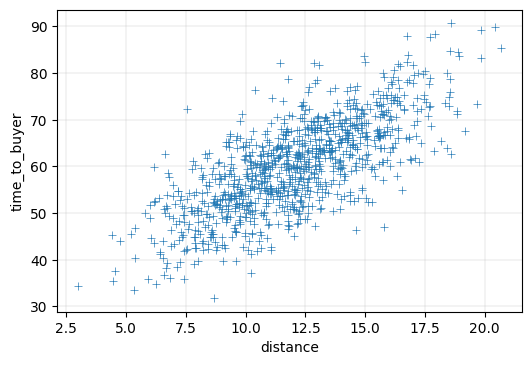

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=test_df, x="distance", y="time_to_buyer", marker='+')
plt.grid(linestyle='-', linewidth=0.2)

## We train 3 models here: 1 for each quantile

In [ ]:
classifiers = {}
for tau in [0.1, 0.5, 0.9]:
    clf = LGBMRegressor(objective='quantile', alpha=tau)
    clf.fit(X_train, y_train)
    preds = pd.DataFrame(clf.predict(X_test), columns = [str(tau)])
    classifiers[str(tau)] = {'clf': clf, 'predictions': preds}

In [ ]:
# combine the predictions
data = pd.DataFrame({'distance': X_test.reset_index()['distance'],
              '0.1': classifiers['0.1']['predictions']['0.1'],
              '0.5': classifiers['0.5']['predictions']['0.5'],
              '0.9': classifiers['0.9']['predictions']['0.9'],
              'time_to_buyer': y_test.reset_index()['time_to_buyer']})

In [ ]:
# time to buyer between the 0.1 and 0.9 quantile, 0.5 is the mean 

data.sample(3)


,distance,0.1,0.5,0.9,time_to_buyer
195,13.651688,57.347890,63.583914,73.849502,71.611806
1,9.406113,48.954547,55.100773,63.350868,58.426020
167,8.666902,44.740436,53.276057,61.912384,53.033034


In [ ]:
melted_data = pd.melt(data, id_vars=['distance'])

In [ ]:
# melted_data = melted_data[:3000]

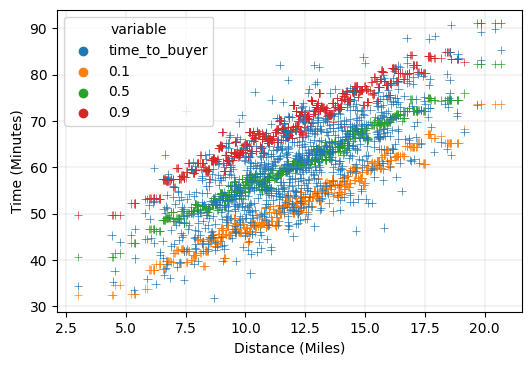

In [ ]:
plt.rcParams.update({'font.size': 10, 'figure.dpi':100})
sns.scatterplot(data=melted_data, 
                x="distance",
                y='value',
                hue='variable',
                hue_order=['time_to_buyer', '0.1', '0.5', '0.9'],
                marker='+')
plt.grid(linestyle='-', linewidth=0.2)
ylabel = plt.ylabel("Time (Minutes)")
xlabel = plt.xlabel("Distance (Miles)")

In [ ]:
(data['time_to_buyer'] > data['0.1']).value_counts()

True     876
False    124
dtype: int64

In [ ]:
(data['time_to_buyer'] > data['0.5']).value_counts()

False    532
True     468
dtype: int64

In [ ]:
(data['time_to_buyer'] > data['0.9']).value_counts()

False    900
True     100
dtype: int64

### Notes

- Instacart: https://tech.instacart.com/how-instacart-delivers-on-time-using-quantile-regression-2383e2e03edb
- Quantile Regression blog: http://ethen8181.github.io/machine-learning/ab_tests/quantile_regression/quantile_regression.html